# Домашнее задание. Композиции алгоритмов
В этом домашнем задании вам предстоит обучить два вида композиций алгоритмов: бэггинг и бустинг.

## Постановка задачи
Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week

## Метрика качества
В качестве целевой метрики мы будем использовать ROC-AUC. Об этой метрике мы говорили в модуле о метриках. Как вы помните, для измерения ROC-AUC требуются вероятности принадлежности к классам. Для решающих деревьев вероятность принадлежности к классу вычисляется как доля объектов из обучающей выборки в соответствующем листе. Для алгоритма, который принимает решение взвешенным голосованием, вероятность вычисляется как среднее взвешенное значение вероятностей по всем алгоритмам в композиции.

## Ход работы
* Первым делом вы произведете загрузку и обработку данных. В частности, вам необходимо будет закодировать категориальные признаки с помощью One-hot encoding.
* Сначала мы построим для нашей задачи обычный случайный лес и измерим его качество. Мы подберем оптимальный гиперпараметр "глубина дерева" для случайного леса.
* Далее мы обучим алгоритм градиентного бустинга с помощью библиотеки Catboost. Catboost --- это библиотека для градиентного бустинга, которая автоматически обрабатывает категориальные признаки. Поэтому для этого пункта вам нужно будет использовать не One-hot признаки, а изначальные категориальные признаки.

## Оценивание
В этом домашнем задании данные разделены на две части:
* [`data_train.csv`](https://drive.google.com/file/d/1qKakViWhNT1yTiM66V9hxADAVCYTL0PO/view?usp=share_link). Для этих данных вам известно значение целевой переменной. Эти данные вы будете использовать для обучения.
* [`data_scoring.csv`](https://drive.google.com/file/d/1tguHTZm9-sUwTRzqAEuqLRUzKHqkvVmQ/view?usp=share_link). На этих данных вы должны будете применить готовую модель, а затем сдать результаты в Stepik. Вам необходимо будет сдать результат работы двух моделей: случайного леса и градиентного бустинга.



## Часть 1. Загрузка и обработка данных
Загрузка данных будет состоять из следующих шагов:
* Загрузка из файла;
* Работа с пропущенными значениями;
* Выделение целевой переменной;
* Разбиение данных на вещественные и категориальные;
* One-hot кодирование категориальных данных;
* Разбиение данных на train и test.

Затем все эти шаги (кроме последнего) необходимо будет применить к `data_scoring`.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
!gdown 1qKakViWhNT1yTiM66V9hxADAVCYTL0PO #эта команда скачивает файл data_train.csv и помещает его в корневую директорию Colab. Очень удобно!

Downloading...
From: https://drive.google.com/uc?id=1qKakViWhNT1yTiM66V9hxADAVCYTL0PO
To: /content/data_train.csv
100% 1.40M/1.40M [00:00<00:00, 69.0MB/s]


In [215]:
data = pd.read_csv('data_train.csv')

In [ ]:
data.shape

(14734, 14)

In [ ]:
data[:10]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
5,18,Private,446771,Some-college,10,Never-married,Adm-clerical,Own-child,White,Male,0,0,25,<=50K
6,31,Federal-gov,108464,Assoc-acdm,12,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,<=50K
7,18,?,423460,11th,7,Never-married,?,Own-child,White,Male,0,0,36,<=50K
8,25,Private,110138,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,40,<=50K
9,53,Federal-gov,167410,Bachelors,13,Divorced,Tech-support,Not-in-family,Amer-Indian-Eskimo,Male,0,0,40,<=50K


### Задание
Проведите с данными необходимые операции:

* Замените все знаки "?" на `np.nan`.
* Найдите все столбцы со значениями NaN. Напечатайте их названия.
* Выделите вектор ответов. Закодируйте правильные ответы 0 и 1:
    * '<=50K' -> 0;
    * '>50K' -> 1.
* Сохраните их в отдельную переменную `y` типа `np.array`.
* Удалите из data правильные ответы.

In [216]:
data = data.replace(['?'], np.nan)
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14729,18,Private,395567,HS-grad,9,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,40,<=50K
14730,62,NaN,94931,Assoc-voc,11,Married-civ-spouse,NaN,Husband,White,Male,3411,0,40,<=50K
14731,34,Private,261023,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,1651,38,<=50K
14732,26,Private,195327,HS-grad,9,Never-married,Sales,Own-child,White,Male,0,0,40,<=50K


**Вопрос**. В каких колонках присутствуют пропущенные значения?

In [5]:
# Найдите колонки с пропущенными значениями
data.isna().sum()

age                 0
workclass         860
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        864
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
>50K,<=50K          0
dtype: int64

In [217]:
# ВАШ КОД
y = data['>50K,<=50K'].apply(lambda x: 1 if x == '>50K' else 0)
y = y.astype(np.int32, copy=False)
y

0        0
1        0
2        0
3        0
4        1
        ..
14729    0
14730    0
14731    0
14732    0
14733    0
Name: >50K,<=50K, Length: 14734, dtype: int32

Удалим ответы из data.

In [218]:
data = data.drop('>50K,<=50K', 1)

<ipython-input-218-39d7579a6e80>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop('>50K,<=50K', 1)


**Вопрос**. Какие из признаков являются вещественными?

Выделите вещественные и категориальные признаки.

In [220]:
real_columns = [i for i in data.columns if data[i].dtypes == 'int64']

real_data = data[real_columns]
real_data[:10]

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40
5,18,446771,10,0,0,25
6,31,108464,12,0,0,40
7,18,423460,7,0,0,36
8,25,110138,9,0,0,40
9,53,167410,13,0,0,40


In [221]:
cat_columns = [i for i in data.columns if data[i].dtypes == 'object']

cat_data = data[cat_columns]
cat_data[:10]

,workclass,education,marital-status,occupation,relationship,race,sex
0,Local-gov,HS-grad,Never-married,Farming-fishing,Not-in-family,Black,Male
1,Private,Some-college,Divorced,Sales,Not-in-family,White,Male
2,Local-gov,Bachelors,Married-civ-spouse,Prof-specialty,Own-child,White,Male
3,Private,Some-college,Never-married,Sales,Own-child,White,Female
4,Private,Bachelors,Married-civ-spouse,Tech-support,Husband,White,Male
5,Private,Some-college,Never-married,Adm-clerical,Own-child,White,Male
6,Federal-gov,Assoc-acdm,Married-civ-spouse,Tech-support,Husband,White,Male
7,NaN,11th,Never-married,NaN,Own-child,White,Male
8,Private,HS-grad,Never-married,Other-service,Not-in-family,White,Male
9,Federal-gov,Bachelors,Divorced,Tech-support,Not-in-family,Amer-Indian-Eskimo,Male


### Задание
Выделите One-hot признаки из данных с помощю объекта `OneHotEncoder` из модуля `sklearn.preprocessing`.

In [209]:
from sklearn.preprocessing import OneHotEncoder

In [222]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
one_hot_data = ohe.fit_transform(cat_data)
one_hot_data = pd.DataFrame(one_hot_data, index=cat_data.index, columns=ohe.get_feature_names_out())
one_hot_data[:10]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,workclass_nan,education_10th,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


Наконец, разобьем данные на train и test в соотношении 70:30.

In [223]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_real_data, test_real_data, \
train_cat_data, test_cat_data, train_one_hot_data, test_one_hot_data, \
y_train, y_test = train_test_split(data, real_data,
                                   cat_data, one_hot_data,
                                   y, train_size=0.7)

In [231]:
y_test.shape

(4421,)

### Задание
Проделайте все то же самые операции для scoring_data.
* Загрузите данные из файла data_scoring.csv;
* Замените "?" на `np.nan`;
* Выделите числовые и категориальные данные;
* Закодируйте категориальные данные с помощью уже созданного `ohe`. Новый объект класса `OneHotEncoding` создавать не нужно. Используйте метод `ohe.transform`.

In [14]:
!gdown 1tguHTZm9-sUwTRzqAEuqLRUzKHqkvVmQ

Downloading...
From: https://drive.google.com/uc?id=1tguHTZm9-sUwTRzqAEuqLRUzKHqkvVmQ
To: /content/data_scoring.csv
100% 139k/139k [00:00<00:00, 49.4MB/s]


In [ ]:
scoring_data = pd.read_csv('data_scoring.csv')

scoring_data = scoring_data.replace(['?'], np.nan)
scoring_real_data = scoring_data[[i for i in scoring_data.columns if scoring_data[i].dtypes == 'int64']]
scoring_cat_data = scoring_data[[i for i in scoring_data.columns if scoring_data[i].dtypes == 'object']]
scoring_one_hot_data = ohe.fit_transform(scoring_cat_data)
scoring_one_hot_data = pd.DataFrame(scoring_one_hot_data, index=scoring_cat_data.index, columns=ohe.get_feature_names_out())

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Часть 2. Обучение случайного леса
Мы будем использовать модель `RandomForestClassifier` из `sklearn.ensemble`. Вам предстоит подобрать для случайного леса оптимальный параметр глубины. Количество деревьев в этом задании мы будем использовать постоянным и равным 100.

Выбор параметра мы будем производить с помощью кросс-валидации на 5 фолдов, используя метод `cross_val_score` из `sklearn.model_selection`. Затем мы обучим окончательную модель на всем `train_data`, а на `test_data` будем считать итоговое качество.

Отметим, что для моделей `sklearn` мы не можем по умолчанию использовать категориальные признаки. Поэтому мы будем использовать `train/test_one_hot_data`.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

Создадим полную матрицу объекты-признаки. Используем числовые и one-hot данные.

In [29]:
train_data_for_forest = pd.concat([train_real_data, train_one_hot_data], axis='columns')
test_data_for_forest = pd.concat([test_real_data, test_one_hot_data], axis='columns')

### Задание
Выберите оптимальный параметр max_depth от 3 до 19 включительно для модели случаного леса. Используйте кросс-валидацию. Для каждой глубины посчитайте среднее по фолдам значение метрики ROC-AUC и запишите получившиеся данные в массив `rf_metrics`. Используйте 5 фолдов для кросс-валидации.

**Совет**. Для ускорения работы функции `cross_val_score` используйте параметр n_jobs=-1.

In [115]:
depths = np.arange(3, 20)
rf_metrics = []

for depth in depths:
    scores = cross_val_score(RandomForestClassifier(), train_one_hot_data, y_train, cv=5, n_jobs=-1)

    rf_metrics.append(np.mean(scores))

KeyboardInterrupt: 

Построим график получившейся метрики в зависимости от параметра `depth`.

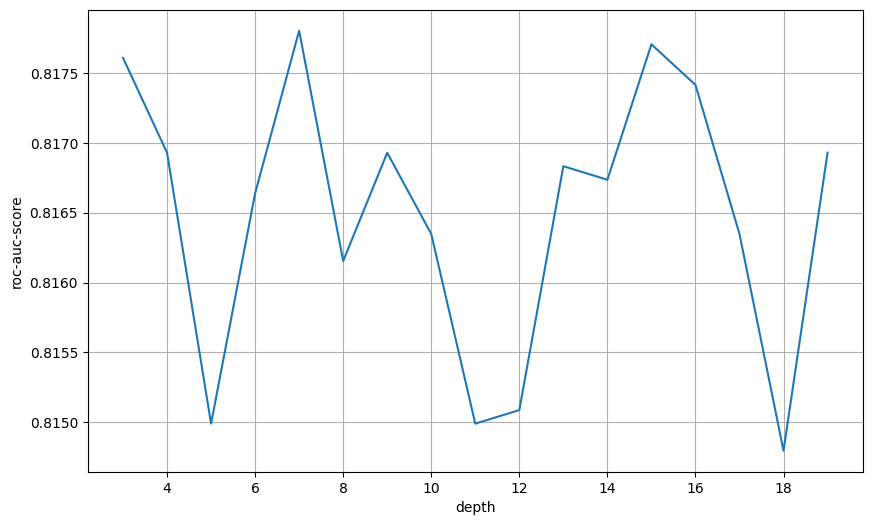

In [18]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(3, 20), rf_metrics)
plt.xlabel('depth')
plt.ylabel('roc-auc-score')
plt.grid()

### Задание
Выберите оптимальное значение глубины и обучите для этого значения единственную модель `RandomForestClassifier` на всех обучающих данных `train_data_for_forest`. Предскажите вероятность класса 1 на обучающих и тестовых данных. Сохраните их в переменные `train_y_pred_forest` и `test_y_pred_forest`. Используйте метод `predict_proba`.

In [ ]:
best_depth = 19

model = RandomForestClassifier(n_estimators=100, max_depth=best_depth)
#ВАШ КОД. Обучите модель
model.fit(train_data_for_forest, y_train)

train_y_pred_forest = model.predict_proba(train_data_for_forest)[:, 1]
test_y_pred_forest = model.predict_proba(test_data_for_forest)[:, 1]

### Задание
Вычислите ROC-AUC на обучающем и тестовом множестве.

In [259]:
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
train_auc = roc_auc_score(y_train, train_y_pred_forest)
test_auc = roc_auc_score(y_test, test_y_pred_forest)

In [ ]:
train_auc, test_auc

(0.9911291758832098, 0.9077877916468118)

Проверим, что мы получили достаточно хорошие значения для `test_auc`.

In [ ]:
assert test_auc > 0.90

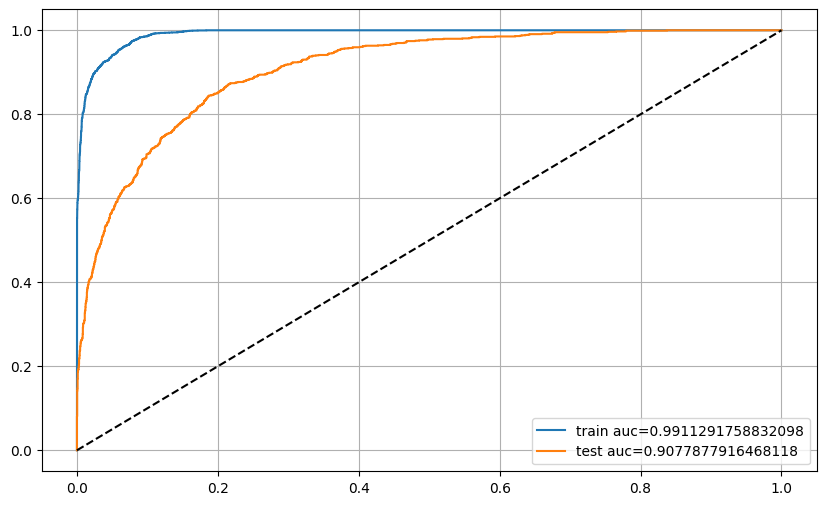

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(*roc_curve(y_train, train_y_pred_forest)[:2],
         label=f'train auc={train_auc}')
plt.plot(*roc_curve(y_test, test_y_pred_forest)[:2],
         label=f'test auc={test_auc}')


plt.plot([0,1], [0,1], '--', color='black')
plt.legend()
plt.grid()

### Задание
Создайте датасет `scoring_data_for_forest` и предскажите на нем целевую переменную.

In [138]:
data_train = pd.read_csv('data_train.csv')
scoring_data = pd.read_csv('data_scoring.csv')

In [139]:
data_train = data_train.replace(['?'], np.nan)
data_train['>50K,<=50K'] = data_train['>50K,<=50K'].apply(lambda x: 1 if x == '>50K' else 0)

In [140]:
X_train = data_train.drop(columns='>50K,<=50K')
y_train = data_train['>50K,<=50K']
y_train = y.astype(np.int32, copy=False)

In [142]:
real_columns = [i for i in X_train.columns if X_train[i].dtypes == 'int64']
train_real_data = X_train[real_columns]

cat_columns = [i for i in X_train.columns if X_train[i].dtypes == 'object']
train_cat_data = X_train[cat_columns]

In [143]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
train_one_hot_data = ohe.fit_transform(train_cat_data)
train_one_hot_data = pd.DataFrame(train_one_hot_data, index=train_cat_data.index, columns=ohe.get_feature_names_out())

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [144]:
scoring_data = scoring_data.replace(['?'], np.nan)
scoring_real_data = scoring_data[[i for i in scoring_data.columns if scoring_data[i].dtypes == 'int64']]
scoring_cat_data = scoring_data[[i for i in scoring_data.columns if scoring_data[i].dtypes == 'object']]
scoring_one_hot_data = ohe.fit_transform(scoring_cat_data)
scoring_one_hot_data = pd.DataFrame(scoring_one_hot_data, index=scoring_cat_data.index, columns=ohe.get_feature_names_out())

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [145]:
common_columns = train_one_hot_data.columns.intersection(scoring_one_hot_data.columns)
train_one_hot_data = train_one_hot_data[common_columns]

In [146]:
train_data_for_forest = pd.concat([train_real_data, train_one_hot_data], axis='columns')

In [147]:
scoring_data_for_forest = pd.concat([scoring_real_data, scoring_one_hot_data], axis='columns')

In [188]:
depths = np.arange(3, 20)
rf_metrics = []

for depth in depths:
    scores = cross_val_score(RandomForestClassifier(), train_data_for_forest, y_train, cv=5, n_jobs=-1)

    rf_metrics.append(np.mean(scores))

KeyboardInterrupt: 

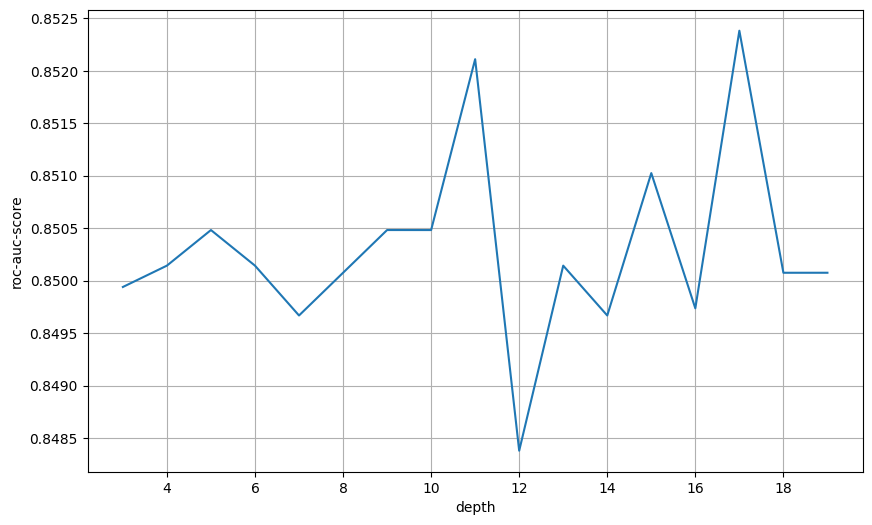

In [171]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(3, 20), rf_metrics)
plt.xlabel('depth')
plt.ylabel('roc-auc-score')
plt.grid()

In [184]:
best_depth = 19

model = RandomForestClassifier(n_estimators=100, max_depth=best_depth)
#ВАШ КОД. Обучите модель
model.fit(train_data_for_forest, y_train)

scoring_y_pred_forest = model.predict_proba(scoring_data_for_forest)[:, 1]

In [185]:
scoring_data_for_forest = scoring_data_for_forest
scoring_y_pred_forest = scoring_y_pred_forest

Сохраним scoring_y_pred_forest. Отправьте их на Stepik, полностью скопировав содержимое файла и вставив их вместо "<ВАШ КОД. Вставьте сюда list вероятностей, предсказанных случайным лесом на data_scoring.csv>" так, чтобы переменная answer содержала список вероятностей в нужном порядке.

In [186]:
with open('scoring_y_pred_forest.txt', "w") as f:
    f.write(', '.join([str(item) for item in scoring_y_pred_forest]))

Для посылки на kaggle обычно используют функцию `.to_csv`, как ниже, но нам этот код не понадобится:

In [187]:
pd.Series(scoring_y_pred_forest).to_csv('scoring_y_pred_forest.csv', header=None, index=None)

## Часть 3. Обучение градиентного бустинга
Мы будем использовать библиотеку Catboost. Catboost --- это библиотека для градиентного бустинга от компании Яндекс. Она, как следует из названия, отличается удобной работой с данными вообще и категориальными признаками с частности. Про Catboost можно прочитать в [официальной документации](https://catboost.ai/en/docs/concepts/python-usages-examples) и в статье на [Хабре](https://habr.com/ru/post/599827/).

<img src="https://avatars.mds.yandex.net/i?id=53d991f7cac35c76bf747793019c39fb-3751806-images-thumbs&n=13&exp=1" style="height:400px; width:800px">

Обратите внимание на следующие моменты:
* В Catboost можно сразу передавать категориальные признаки без предварительного кодирования.
* В Catboost для категориальных признаков необходимо заполнять пропущенные значения. Мы будем заполнять их значениями `'unknown'`.
* Для работы с данными в Catboost [есть специальный класс](https://catboost.ai/en/docs/concepts/python-reference_pool), который называется `Pool`. Прочитать о нем можно также в [примерах использования](https://catboost.ai/en/docs/concepts/python-usages-examples).
* Для кросс-валидации в Catboost [есть специальный класс](https://catboost.ai/en/docs/concepts/python-reference_cv) `cv`. Об использовании можно прочитать в статье на [Хабре](https://habr.com/ru/post/599827/).
* Собственно, основная модель для классификации в Catboost --- это `CatBoostClassifier`.

Для установки `catboost` вы можете выполнить следующую команду.

In [189]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 2.2 MB/s eta 0:00:00


Импортируем все необходимые классы.

In [190]:
from catboost import CatBoostClassifier, Pool, cv

### Задание
Заполните пропуски в данных `train_cat_data` и `test_cat_data` значением `'unknown'`. Используйте метод `fillna`.

In [233]:
train_cat_data = train_cat_data.fillna('unknown')
test_cat_data = test_cat_data.fillna('unknown')

### Задание
Создайте новые наборы данных для train и test, состоящие из `[train/test]_real_data` и `[train/test]_cat_data`. Используйте `pd.concat`. Затем создайте обучающий и тестовый `Pool` (за вас мы выделили номера категориальных признаков).

In [239]:
train_data_for_boosting = pd.concat([train_real_data, train_cat_data], axis='columns')
test_data_for_boosting = pd.concat([test_real_data, test_cat_data], axis='columns')

cat_features = np.arange(train_cat_data.shape[1]) + train_real_data.shape[1]

train_dataset = Pool(data=train_data_for_boosting,
                     label=y_train,
                     cat_features=cat_features)

#cat_features = np.arange(test_cat_data.shape[1]) + test_real_data.shape[1]

test_dataset = Pool(data=test_data_for_boosting,
                     label=y_test,
                     cat_features=cat_features)

Для каждого значения depth от 3 до 16 включительно используйте функцию `cv` для подсчета результатов кросс-валидации. Затем посчитайте среднее по фолдам значение метрики ROC-AUC с последней итерации и запишите получившиеся данные в массив `boosting_metrics`.

Обратите внимание, что функция `cv` должна принимать следующие параметры:
* `pool` (используйте `train_dataset`)
* `params` (используйте параметры, указанные в коде)
* `fold_count` (положите равным 5).

Функция cv возвращает pd.DataFrame с метриками обучения. Вам понадобится колонка `'test-AUC-mean'` и последняя строчка. Обратите внимание, что обучение занимает значительное время! Сначала можете попробовать выполнить этот код для небольшого массива `depths`, чтобы было легче дебагать.

In [253]:
depths = np.arange(3, 17)
boosting_metrics = []

for depth in depths:
    params = {"iterations": 100,
              "depth": depth,
              "loss_function": "Logloss",
              "custom_loss": "AUC",
              "verbose": False}

    scores = cv(pool=train_dataset, params=params, fold_count=5)

    boosting_metrics.append((scores['test-AUC-mean'].iloc[-1]))

Training on fold [0/5]

bestTest = 0.3351863038
bestIteration = 99

Training on fold [1/5]

bestTest = 0.3329531811
bestIteration = 99

Training on fold [2/5]

bestTest = 0.3154210629
bestIteration = 99

Training on fold [3/5]

bestTest = 0.327368618
bestIteration = 99

Training on fold [4/5]

bestTest = 0.3346814585
bestIteration = 99

Training on fold [0/5]

bestTest = 0.3285365439
bestIteration = 99

Training on fold [1/5]

bestTest = 0.326095954
bestIteration = 99

Training on fold [2/5]

bestTest = 0.3084866006
bestIteration = 99

Training on fold [3/5]

bestTest = 0.3227738874
bestIteration = 99

Training on fold [4/5]

bestTest = 0.3250528646
bestIteration = 99

Training on fold [0/5]

bestTest = 0.3230513884
bestIteration = 99

Training on fold [1/5]

bestTest = 0.3215064575
bestIteration = 99

Training on fold [2/5]

bestTest = 0.3048221592
bestIteration = 99

Training on fold [3/5]

bestTest = 0.3186409709
bestIteration = 99

Training on fold [4/5]

bestTest = 0.320680869
bes

In [254]:
boosting_metrics

[0.9056859998271303,
 0.9086575127862189,
 0.9109168722212793,
 0.9127847893146809,
 0.9136617813697997,
 0.9140026949559656,
 0.9147660341498554,
 0.9146791263815228,
 0.9147777339999692,
 0.9142249987835834,
 0.9143726917754815,
 0.9132281563239616,
 0.9127635833672546,
 0.9113739315808234]

Построим график получившейся метрики в зависимости от параметра `depth`. Сравним его с тем же графиком для метрик случайного леса.

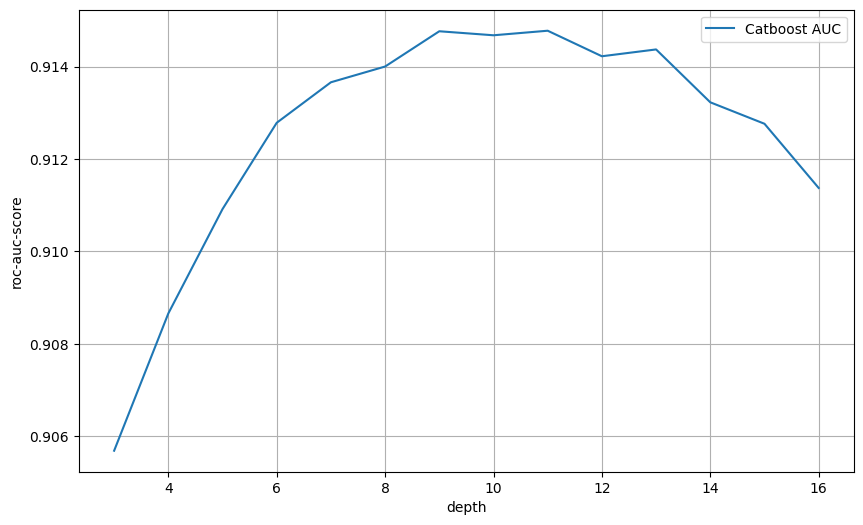

In [256]:
plt.figure(figsize=(10,6))
#plt.plot(np.arange(3, 20), rf_metrics, label='Random Forest AUC')
plt.plot(np.arange(3, 17), boosting_metrics, label='Catboost AUC')
plt.xlabel('depth')
plt.ylabel('roc-auc-score')
plt.grid()
plt.legend()

Ответье на следующие вопросы:
* Для какой модели общие результаты получились лучше? Если лучше результаты получились у бэггинга, как вы думаете, получится ли у бустинга отыграться на полной выборке и при большем количестве деревьев?
* Какова получилась оптимальная глубина для бустинга?
* Как она отличается от оптимальной глубины для бэггинга?

### Задание
Мы нашли оптмальную глубину. Обучите для этого значения глубины один `CatBoostClassifier` со следующими параметрами:
* `iterations=500` (именно 500, потому что качества с сотней деревьев может не хватить!)
* `depth =` глубина, которую вы нашли
* `loss_function='Logloss'`
* `verbose=False` (чтобы не было лишнего вывода).

Обучение производится с помощью метода `fit`, который принимает единственный аргумент --- `Pool` с данными. В данном случае используйте `train_dataset`.

Предскажите значения на `train_dataset` и `test_dataset`. Это делается методом `predict_proba` (устроен так же, как и в `sklearn`).

In [257]:
best_depth = 11 - 1

model = CatBoostClassifier(iterations=500, depth=best_depth, loss_function='Logloss', verbose=False)

#ВАШ КОД. Обучите модель на train_dataset
model.fit(train_dataset)

train_y_pred_boosting = model.predict_proba(train_dataset)[:, 1]
test_y_pred_boosting = model.predict_proba(test_dataset)[:, 1]

### Задание
Вычислите ROC-AUC на обучающем и тестовом множестве.

In [268]:
train_auc = roc_auc_score(y_train, train_y_pred_boosting)
test_auc = roc_auc_score(y_test, test_y_pred_boosting)

In [269]:
train_auc, test_auc

(0.9769664807119985, 0.9211796764365104)

Проверим, что мы получили достаточно хорошие значения для `test_auc`.

In [270]:
assert test_auc > 0.915

Построим ROC-кривые для получившейся модели.

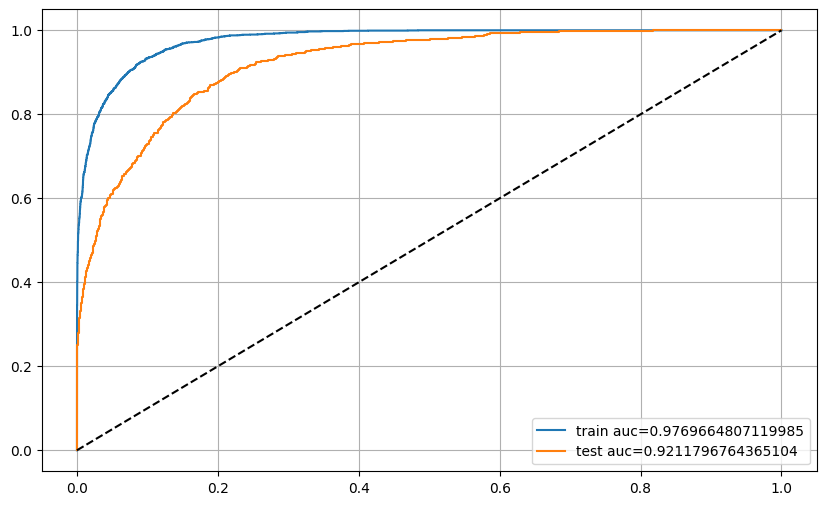

In [271]:
plt.figure(figsize=(10,6))
plt.plot(*roc_curve(y_train, train_y_pred_boosting)[:2],
         label=f'train auc={train_auc}')
plt.plot(*roc_curve(y_test, test_y_pred_boosting)[:2],
         label=f'test auc={test_auc}')

plt.plot([0,1], [0,1], '--', color='black')

plt.legend()
plt.grid()

### Задание
Примените построенную модель к данным `scoring_data`. Для этого повторите все шаги, которые вы делали с тестовыми данными:
* Заполнение пропущенных значений
* Конкатенация числовых и категориальных данных
* Создание `scoring_dataset` (здесь не нужно передавать аргумент `label`, так как мы их не знаем)
* Предсказание вероятностей 1 класса

In [277]:
data_train = pd.read_csv('data_train.csv')
scoring_data = pd.read_csv('data_scoring.csv')

In [280]:
data_train = data_train.replace(['?'], 'unknown')
data_train['>50K,<=50K'] = data_train['>50K,<=50K'].apply(lambda x: 1 if x == '>50K' else 0)

In [281]:
scoring_data = scoring_data.replace(['?'], 'unknown')

In [282]:
X_train = data_train.drop(columns='>50K,<=50K')
y_train = data_train['>50K,<=50K']
y_train = y.astype(np.int32, copy=False)

In [291]:
real_columns = [i for i in X_train.columns if X_train[i].dtypes == 'int64']
train_real_data = X_train[real_columns]

cat_columns = [i for i in X_train.columns if X_train[i].dtypes == 'object']
train_cat_data = X_train[cat_columns]

In [293]:
cat_columns

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex']

In [ ]:
real_columns = [i for i in scoring_data.columns if scoring_data[i].dtypes == 'int64']
test_real_data = scoring_data[real_columns]

cat_columns = [i for i in scoring_data.columns if scoring_data[i].dtypes == 'object']
test_cat_data = scoring_data[cat_columns]

In [294]:
#train_data_for_boosting = pd.concat([train_real_data, train_cat_data], axis='columns')
#test_data_for_boosting = pd.concat([test_real_data, test_cat_data], axis='columns')

#cat_features = np.arange(train_cat_data.shape[1]) + train_real_data.shape[1]

train_dataset = Pool(data=X_train,
                     label=y_train,
                     cat_features=cat_columns)

In [295]:
best_depth = 11 - 1

model = CatBoostClassifier(iterations=500, depth=best_depth, loss_function='Logloss', verbose=False)

#ВАШ КОД. Обучите модель на train_dataset
model.fit(train_dataset)

scoring_y_pred_boosting = model.predict_proba(scoring_data)[:, 1]

Сохраним предсказанные значения. Отправьте их на Stepik.

In [297]:
with open('scoring_y_pred_boosting.txt', "w") as f:
    f.write(', '.join([str(item) for item in scoring_y_pred_boosting]))